# Data Scientist: Module 2 Demonstration (Supervised Machine Learning)

In this Notebook the learned functionality should be demonstrated on 3 questions on the topic of development indicators of different nations. The data is taken from the site of the Worldbank (see (here)[https://databank.worldbank.org/source/world-development-indicators/preview/on#]). Questions based on the data:

- Is there a connection between economic success and income euqlity? This should be demonstrated by using linear regression
- which feature can best explain the literacy rate of a country using Shaply values
- classify countries into those with a low and a high literacy rate based on economic success and evaluate the predictions using a Confusion Matrix

The data is from 2020, since the most recent data from 2023 contains more missing data. 

## Question 1: Dependency between economix success and income euality

The x values are the GNI (Gross National Income per capita) and the y values are the Gini coefficients of the countries (high GINI = high inequality)

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [3]:
df = pd.read_csv("worldbank_development.csv", sep=',')
df = df.dropna(how='any',axis=0)
df.head(1)

,Time,Time Code,Country Name,Country Code,"Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]","Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]",Births attended by skilled health staff (% of total) [SH.STA.BRTC.ZS],"Contraceptive prevalence, any method (% of married women ages 15-49) [SP.DYN.CONU.ZS]",Domestic credit provided by financial sector (% of GDP) [FS.AST.DOMS.GD.ZS],Electric power consumption (kWh per capita) [EG.USE.ELEC.KH.PC],...,"School enrollment, primary (% gross) [SE.PRM.ENRR]","School enrollment, primary and secondary (gross), gender parity index (GPI) [SE.ENR.PRSC.FM.ZS]","School enrollment, secondary (% gross) [SE.SEC.ENRR]",Surface area (sq. km) [AG.SRF.TOTL.K2],Tax revenue (% of GDP) [GC.TAX.TOTL.GD.ZS],Terrestrial and marine protected areas (% of total territorial area) [ER.PTD.TOTL.ZS],"Total debt service (% of exports of goods, services and primary income) [DT.TDS.DECT.EX.ZS]",Urban population growth (annual %) [SP.URB.GROW],Gini index [SI.POV.GINI],Research and development expenditure (% of GDP) [GB.XPD.RSDV.GD.ZS]
0,2020,YR2020,Argentina,ARG,31.492,6.35703367575527,98.8,70.1027087175867,45.7796388175674,2827.42739776861,...,110.617813110352,1.0242600440979,112.416679382324,2780400,10.8658963820494,9.4,43.0976319782414,0.615028911928924,42.7,0.541260004043579


The csv files contains missing data that is indicated as `..`, so the data is transformed:

In [4]:
class GNIGini:

    def __init__(self, gni, gini, country):
        self.gni = self.to_float(gni)
        self.gini = self.to_float(gini)
        self.country = country

    def to_float(self, value) -> float:
        if isinstance(value, str):
            return float(value)
        return value


x_column_name = "GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]"   
y_column_name = "Gini index [SI.POV.GINI]"
data: list[GNIGini] = []
for index, row in df.iterrows():
    # Only use rows that have all needed data:
    if row[x_column_name] and row[x_column_name] != "..":
        if row[y_column_name] and row[y_column_name] != "..":
            data.append(GNIGini(gni=row[x_column_name], gini=row[y_column_name], country=row["Country Name"]))
data = sorted(data, key=lambda x: x.gni, reverse=False)

x_list = [[elem.gni] for elem in data]
y_list = [elem.gini for elem in data]
countries = [elem.country for elem in data]

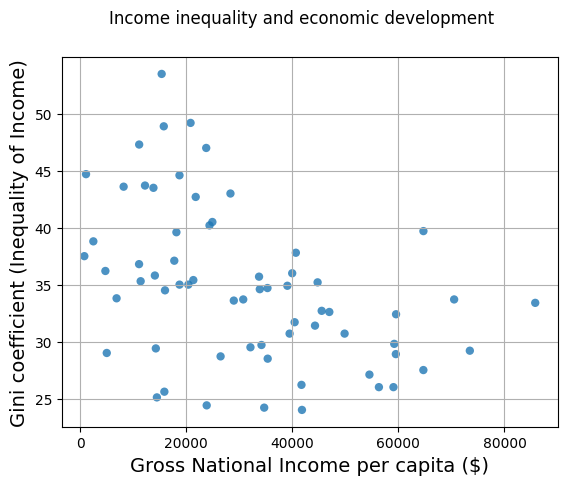

In [5]:
# Show how each country is located in a coordinate system with economix success an the x-axis
# and income inequality on the y axis
fig, ax = plt.subplots()
fig.suptitle("Income inequality and economic development")
ax.scatter([elem.gni for elem in data], [elem.gini for elem in data], alpha=0.8, edgecolors='none')
ax.grid(True)
ax.set_xlabel("Gross National Income per capita ($)", size=14)
ax.set_ylabel("Gini coefficient (Inequality of Income)", size=14)
plt.show()

As you can see there is no real linear dependency between the two features but it can be approximated by a curve from the top left
to the bottom right with a slight upward drift in the high income region. So a simple summary would be that a high income inequality 
is more probable in low income countries. Now a linear model should be fit to the data points:

In [6]:
# split the data into training (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
root_mean_squared_error(y_test, y_pred)

7.496672511131307

No show the line that was used for predictions and label thosse countries that where predicted with a significant error:

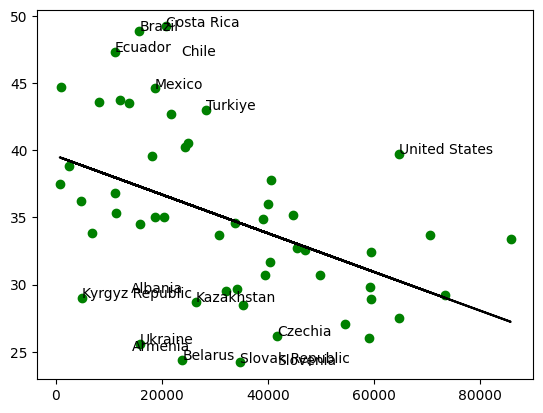

In [9]:
plt.scatter(X_train, y_train,color='g')
plt.plot(X_train, linear_model.predict(X_train),color='k') # the predicition line
predicitions_all = linear_model.predict(x_list)
for idx, val in enumerate(x_list):
    gini_actual = y_list[idx]
    estimated = predicitions_all[idx]
    distance = math.fabs(estimated - gini_actual)
    if distance > 7:
        plt.annotate(countries[idx], (val[0], gini_actual))

plt.show()

## Question 2: Explain the target variable Literacy

In [10]:
import shap
import xgboost

x_columns = [
    "GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]",
    "Population density (people per sq. km of land area) [EN.POP.DNST]",
    "Mortality rate, under-5 (per 1,000 live births) [SH.DYN.MORT]",
    "Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]",
    "Primary completion rate, total (% of relevant age group) [SE.PRM.CMPT.ZS]"
]
feature_names = ["GNI", "Pop. Density", "Mort Rate", "HIV", "Primary School completed"]
y_column = "Life expectancy at birth, total (years) [SP.DYN.LE00.IN]"

class DataRow:

    def __init__(self, gni, pop_dens, mortality_rate, hiv, primary, country):
        self.gni = self.to_float(gni)
        self.pop_dens = self.to_float(pop_dens)
        self.mortality_rate = self.to_float(mortality_rate)
        self.hiv = self.to_float(hiv)
        self.primary = self.to_float(primary)
        self.country = country

    @staticmethod
    def to_float(value) -> float:
        if isinstance(value, str):
            return float(value)
        return value

    def to_list(self):
        return [self.gni, self.pop_dens, self.mortality_rate, self.hiv, self.primary]

    def to_dict(self):
        return vars(self)
        

data = []
y_data: list[float] = []
for index, row in df.iterrows():
    elem_data = []
    invalid = False
    for col in x_columns:
        if not row[col]:
            invalid = True
            break
        if row[col] == "..":
            invalid = True
            break
        elem_data.append(row[col])

    if not invalid:
        data.append(DataRow(*elem_data, country=row["Country Name"]).to_list())
        y_data.append(float(row[y_column]))

In [11]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2)
model = xgboost.XGBRegressor().fit(X_train, y_train)

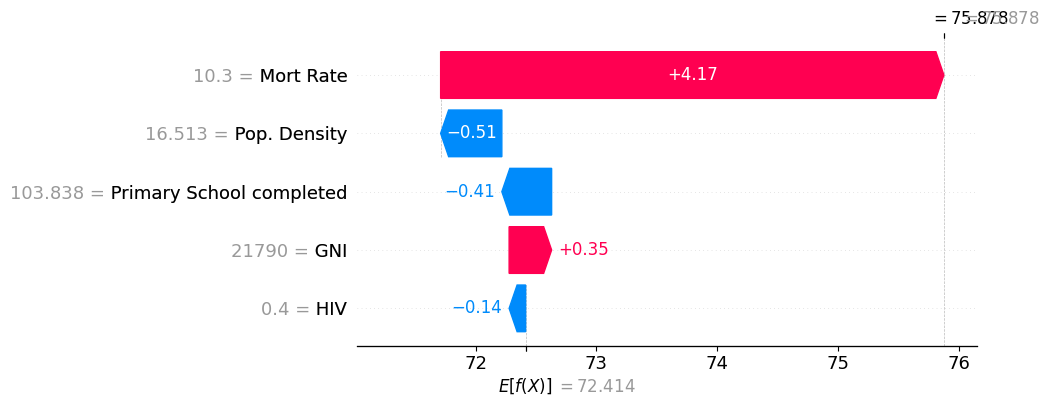

In [12]:
# Visualize feature importance:
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(data)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Explanation: 75.878 is the actual life expectancy of the first country that was used for model training. 

## Question 3: Confusion Matrix

Since there are no categorical values present in the data set the life expectancy is used to create two classes: high and low countries, the threshold being the 75th percentil = 77.4 years. It should be predicted if a country is in the high or low class. First create a descriptive statistic: 

In [13]:
life_exp = df[df["Life expectancy at birth, total (years) [SP.DYN.LE00.IN]"] != ".."]
life_exp = life_exp["Life expectancy at birth, total (years) [SP.DYN.LE00.IN]"]
life_exp.astype(float).describe()

count    265.000000
mean      72.175783
std        7.216460
min       50.596000
25%       66.924000
50%       72.647321
75%       77.449874
max       86.089000
Name: Life expectancy at birth, total (years) [SP.DYN.LE00.IN], dtype: float64

In [21]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier

y_data = [elem > 77.4 for elem in y_data]
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2)
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred, labels=[False, True])


array([[26,  0],
       [ 0,  0]])

In [24]:
print("Recall", recall_score(y_test, y_pred, average='micro'))
print("Precision", precision_score(y_test, y_pred, average='micro'))
print("F1", f1_score(y_test, y_pred, average='micro'))

Recall 1.0
Precision 1.0
F1 1.0
